[View in Colaboratory](https://colab.research.google.com/github/victwise/Uncertainty_estimate/blob/master/uncertainty_estimate.ipynb)

In [0]:
#imports
import datetime as dt
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

In [0]:
#Generando datos falsos
def generate_time_series(k=200, m=1000, sigma=100, n=50,
                        start_date=dt.date(2018,7,1)):
  xs = np.linspace(0,1,n,endpoint=False)
  ys = [k*x + m + rd.gauss(0,sigma) for x in xs]
  ts = [start_date + dt.timedelta(x)*365 for x in xs]
  x_scale = np.linspace(-1,2,500) #for plotting
  t_scale = [start_date + dt.timedelta(x)*365 for x in x_scale]
  return xs, ys, ts, x_scale, t_scale

xs, ys, ts, x_scale, t_scale = generate_time_series()

Text(0,0.5,'Weight of elephant (kg)')

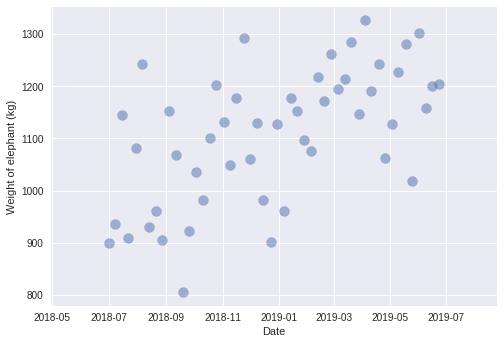

In [5]:
#Generando gráficos
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.xlabel('Date')
plt.ylabel('Weight of elephant (kg)')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


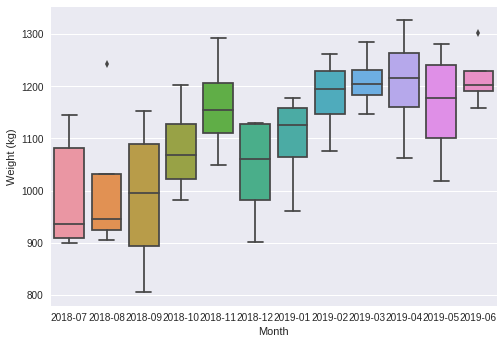

In [6]:
#Hallando la incertidumbre en un intervalo de tiempo
d = pd.DataFrame({'x': xs, 't': ts, 'Weight (kg)': ys})
d['Month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
sns.boxplot(data=d, x='Month', y='Weight (kg)')

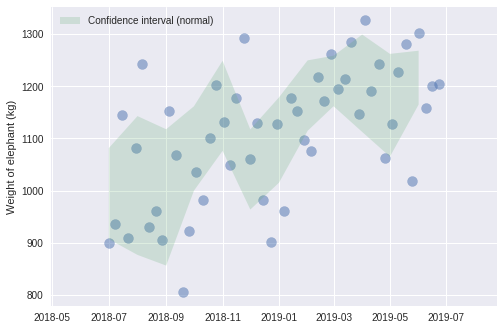

In [7]:
#Calculando los intervalos de confianza x ± 1.96σ/√n
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = np.mean(series), np.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    plt.fill_between(groups, lo_bound, hi_bound, alpha=0.2,
                        label='Confidence interval (normal)')

plt.scatter(ts, ys, alpha=0.5, s=100)
observations_by_month = {}
for month, y in zip(d['Month'], d['Weight (kg)']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
plt.ylabel('Weight of elephant (kg)')
plt.legend() 

In [0]:
#Intervalos de confianza cuando los resultados son 0 o 1
STATES = ['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'OH']
GROUPS = ['test', 'control']

def generate_binary_categorical(states=STATES, groups=GROUPS, k=400,
                                zs=[0, 0.2], z_std=0.1, b=-3, b_std=1):
    output = {}
    e_obs_per_state = np.random.exponential(k, size=len(states))
    state_biases = np.random.normal(b, b_std, size=len(states))
    for group, z in zip(groups, zs):
        noise = np.random.normal(z, z_std, size=len(states))
        ps = 1 / (1 + np.exp(-(state_biases + noise)))
        ns = np.random.poisson(e_obs_per_state)
        ks = np.random.binomial(ns, ps)
        output[group] = (ns, ks)
    return output

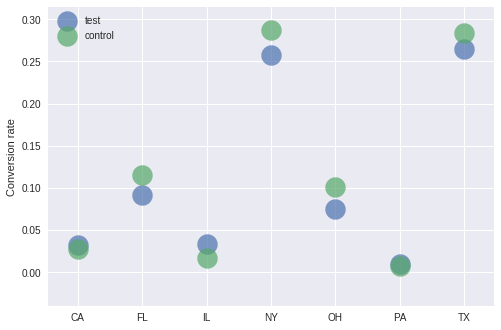

In [11]:
data = generate_binary_categorical()

for group, (ns, ks) in data.items():
    plt.scatter(STATES, ks/ns, label=group, alpha=0.7, s=400)

plt.ylabel('Conversion rate')
plt.legend()

In [12]:
n, k = 100, 3
scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])

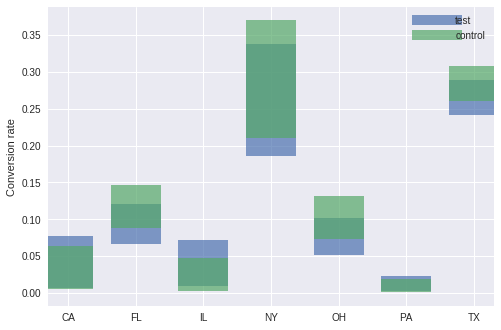

In [13]:
for group, (ns, ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025, ks, ns-ks)
    hi = scipy.stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    plt.errorbar(STATES, y=mean, yerr=[mean-lo, hi-mean],
                    label=group, alpha=0.7, linewidth=0, elinewidth=50)

plt.ylabel('Conversion rate')
plt.legend()

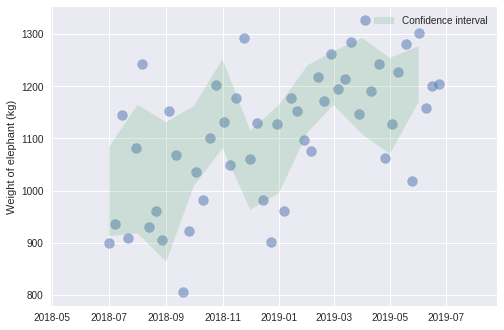

In [14]:
#Bootstraping
#Te permite calcular las mismas estadísticas sin memorizar ninguna fórmula.
#La idea es calcular la media, pero hacerlo por "n bootstraps" , 
#donde cada bootstrap es una muestra aleatoria (con reemplazo) 
#de nuestras observaciones. 
#Para cada bootstrap, calculamos una media, y luego tomamos la media en los 
#percentiles 97.5 y 2.5 como el intervalo de confianza
lo_bound = []
hi_bound = []
months = sorted(observations_by_month.keys())
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        # sample with replacement
        bootstrap = [rd.choice(series) for _ in series]
        bootstrapped_means.append(np.mean(bootstrap))
    lo_bound.append(np.percentile(bootstrapped_means, 2.5))
    hi_bound.append(np.percentile(bootstrapped_means, 97.5))
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.fill_between(months, lo_bound, hi_bound, alpha=0.2,
                    label='Confidence interval')
plt.ylabel('Weight of elephant (kg)')
plt.legend()


Bootstrapping es bueno porque te permite esquivar cualquier pregunta acerca de la distribución de probabilidad desde la que se generan los datos. Básicamente es plug and play, y funciona en casi todo, aunque puede ser un poco lento.

 Tenga en cuenta, sin embargo, que hay una zona peligrosa de arranque. Según tengo entendido, el programa de arranque coincidirá con las estimaciones correctas ya que el número de muestras es infinito, pero si está trabajando con muestras pequeñas, puede obtener resultados realmente extraños.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


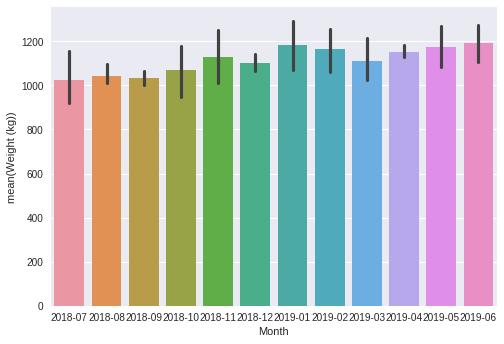

In [31]:
sns.barplot(data=d, x='Month', y='Weight (kg)')


Regresión Lineal

Text(0,0.5,'Weight of elephant (kg)')

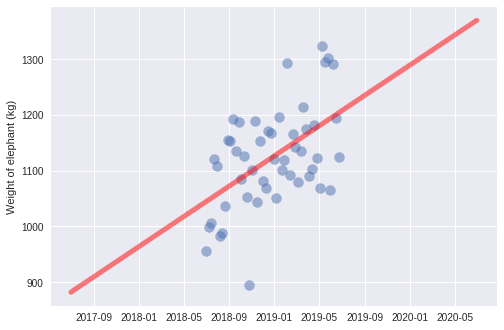

In [15]:
xs, ys, ts, x_scale, t_scale = generate_time_series()

def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return np.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.plot(t_scale, model(x_scale, k_hat, m_hat), color='red',
            linewidth=5, alpha=0.5)
plt.ylabel('Weight of elephant (kg)')

**Probabilidad de Registro**

n/
2
log
2
π
σ**
2
+
1/
2*
σ**
2
∑
(
y
i
−
^
y
i
)
2

No handles with labels found to put in legend.


Text(0,0.5,'Weight of elephant (kg)')

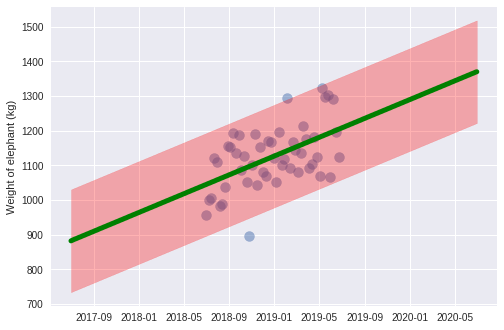

In [16]:
#Regresión lineal con incertidumbre
import scipy.optimize

def neg_log_likelihood(tup, xs, ys):
    # Since sigma > 0, we use use log(sigma) as the parameter instead.
    # That way we have an unconstrained problem.
    k, m, log_sigma = tup
    sigma = np.exp(log_sigma)
    delta = model(xs, k, m) - ys
    return len(xs)/2*np.log(2*np.pi*sigma**2) + \
        np.dot(delta, delta) / (2*sigma**2)

k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
    neg_log_likelihood, (0, 0, 0), args=(xs, ys)
).x
sigma_hat = np.exp(log_sigma_hat)
plt.scatter(ts, ys, alpha=0.5, s=100)
plt.plot(t_scale, model(x_scale, k_hat, m_hat),
            color='green', linewidth=5)
plt.fill_between(
    t_scale,
    model(x_scale, k_hat, m_hat) - 1.96*sigma_hat,
    model(x_scale, k_hat, m_hat) + 1.96*sigma_hat,
    color='red', alpha=0.3)
plt.legend()
plt.ylabel('Weight of elephant (kg)')

Dibujando la estimación con bootstrap

Text(0,0.5,'Weight of elephant (kg)')

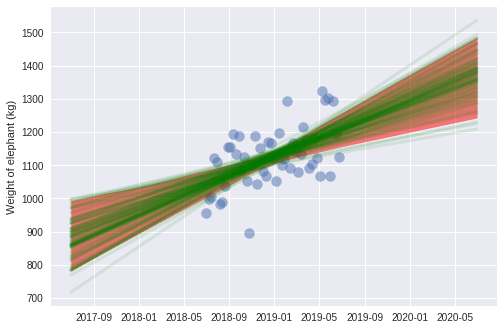

In [17]:
plt.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(100):
    # sample with replacement
    bootstrap = [rd.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x, y in bootstrap])
    ys_bootstrap = np.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(
        l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(model(x_scale, k_hat, m_hat))

# Plot individual lines
for curve in curves:
    plt.plot(t_scale, curve, alpha=0.1, linewidth=3, color='green')

# Plot 95% confidence interval
lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
plt.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
plt.ylabel('Weight of elephant (kg)')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Text(0,0.5,'Weight of elephant (kg)')

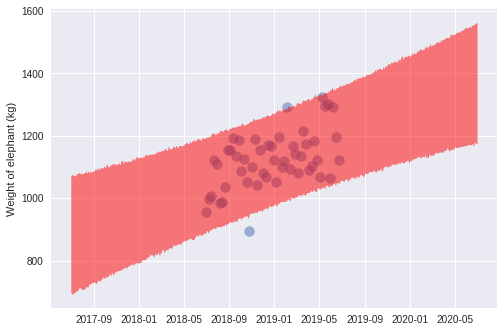

In [18]:
plt.scatter(ts, ys, alpha=0.5, s=100)
xys = list(zip(xs, ys))
curves = []
for i in range(4000):
    # sample with replacement
    bootstrap = [rd.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x, y in bootstrap])
    ys_bootstrap = np.array([y for x, y in bootstrap])
    k_hat, m_hat, log_sigma_hat = scipy.optimize.minimize(
        neg_log_likelihood, (0, 0, 0), args=(xs_bootstrap, ys_bootstrap)
    ).x
    curves.append(
        model(x_scale, k_hat, m_hat) +
        # Note what's going on here: we're _adding_ the random term
	# to the predictions!
        np.exp(log_sigma_hat) * np.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
plt.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
plt.ylabel('Weight of elephant (kg)')

**Resource main:** https://erikbern.com/2018/10/08/the-hackers-guide-to-uncertainty-estimates.html
